# Credit Default Risk Prediction for First-Time Borrowers Using PySpark
## Final Project: Scalable Data Intelligence Platform with PySpark
### Big Data Framework 
#### Professor: Ishant Gupta

## 1. Data Ingestion & Storage

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import DoubleType, IntegerType, StringType

In [2]:
# Step 1: Data ingestion and Storage

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("Credit Default Risk Prediction") \
    .getOrCreate()

# Load Dataset
df_raw = spark.read.csv("loan.csv", header=True, inferSchema=True)

# Display Schema
df_raw.printSchema()

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: integer (nullable = true)
 |-- funded_amnt: integer (nullable = true)
 |-- funded_amnt_inv: double (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: double (nullable = true)
 |-- installment: double (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: strin

In [3]:
# Count total records
print("Total records:", df_raw.count())

# Show sample records
df_raw.show(5)

Total records: 2260668
+----+---------+---------+-----------+---------------+----------+--------+-----------+-----+---------+--------------+----------+--------------+----------+-------------------+--------+-----------+----------+----+----+------------------+------------------+--------+----------+-----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+---------

In [4]:
# Step 2: RDD Basic Transformations

# Convert DataFrame to RDD
df_rdd = df_raw.rdd

# Example transformation: Filter out rows with null values in 'loan_amnt'
rdd_filtered = df_rdd.filter(lambda row: row['loan_amnt'] is not None)

# Example map operation: Create a tuple of (loan_amnt, int_rate)
rdd_mapped = rdd_filtered.map(lambda row: (row['loan_amnt'], row['int_rate']))

# Example reduce operation: Compute total loan amount
total_loan = rdd_mapped.map(lambda x: x[0]).reduce(lambda a, b: a + b)
print("Total loan amount (using RDD reduce):", total_loan)

Total loan amount (using RDD reduce): 34016115925


In [5]:
# Convert back to DataFrame for SQL operations
df_rdd_converted = rdd_mapped.toDF(["loan_amnt", "int_rate"])
df_rdd_converted.show(5)

+---------+--------+
|loan_amnt|int_rate|
+---------+--------+
|     2500|   13.56|
|    30000|   18.94|
|     5000|   17.97|
|     4000|   18.94|
|    30000|   16.14|
+---------+--------+
only showing top 5 rows



In [6]:
# Step 3: SQL Operations

# Register temporary view for SQL queries
df_raw.createOrReplaceTempView("loan_data")

# Run basic SQL query
query_result = spark.sql("""
    SELECT loan_amnt, int_rate, annual_inc
    FROM loan_data
    WHERE loan_amnt IS NOT NULL AND int_rate IS NOT NULL
    LIMIT 5
""")
query_result.show()

+---------+--------+----------+
|loan_amnt|int_rate|annual_inc|
+---------+--------+----------+
|     2500|   13.56|     55000|
|    30000|   18.94|     90000|
|     5000|   17.97|     59280|
|     4000|   18.94|     92000|
|    30000|   16.14|     57250|
+---------+--------+----------+



## 2. Data Cleaning & Exploration

In [7]:
# Step 1: Targeted Null Handling
important_columns = ["loan_amnt", "int_rate", "annual_inc", "loan_status",
                     "open_acc", "mort_acc", "total_acc", "num_rev_accts"]
df_clean = df_raw.dropna(subset=important_columns)
print("Remaining rows after targeted null handling:", df_clean.count())

Remaining rows after targeted null handling: 2190391


In [8]:
# Step 2: Define Binary Target Variable (Filtered)
df_clean = df_clean.filter(col("loan_status").isin("Fully Paid", "Charged Off"))
df_clean = df_clean.withColumn("default_flag", when(col("loan_status") == "Charged Off", 1).otherwise(0))
df_clean.groupBy("default_flag").count().show()

+------------+------+
|default_flag| count|
+------------+------+
|           1|251336|
|           0|984742|
+------------+------+



In [9]:
# Step 3: Drop Columns with High Nulls and Irrelevance
threshold = 0.7
total_rows = df_clean.count()
null_counts = df_clean.select([(count(when(isnull(c), c)) / total_rows).alias(c) for c in df_clean.columns])
null_ratios = null_counts.collect()[0].asDict()
cols_to_drop = [col_name for col_name, ratio in null_ratios.items() if ratio > threshold]
cols_to_drop += ['id', 'member_id', 'url', 'desc', 'emp_title', 'title', 'zip_code']
df_clean = df_clean.drop(*cols_to_drop)
print("Dropped columns:", cols_to_drop)
print("Remaining columns:", len(df_clean.columns))

Dropped columns: ['id', 'member_id', 'url', 'desc', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term', 'id', 'member_id', 'ur

In [10]:
# Step 4: Cast Types
numeric_cols = ["loan_amnt", "int_rate", "annual_inc", "dti", "open_acc", "revol_bal", "total_acc"]
for col_name in numeric_cols:
    df_clean = df_clean.withColumn(col_name, col(col_name).cast("float"))

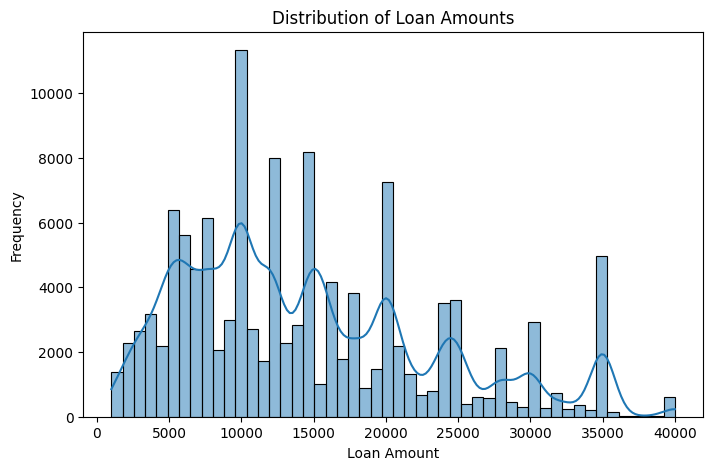

In [11]:
# Step 5: Visualization - Exploration

import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Loan Amounts

loan_amnt_pd = df_clean.select("loan_amnt").sample(False, 0.1).toPandas()
plt.figure(figsize=(8,5))
sns.histplot(loan_amnt_pd["loan_amnt"], bins=50, kde=True)
plt.title("Distribution of Loan Amounts")
plt.xlabel("Loan Amount")
plt.ylabel("Frequency")
plt.show()

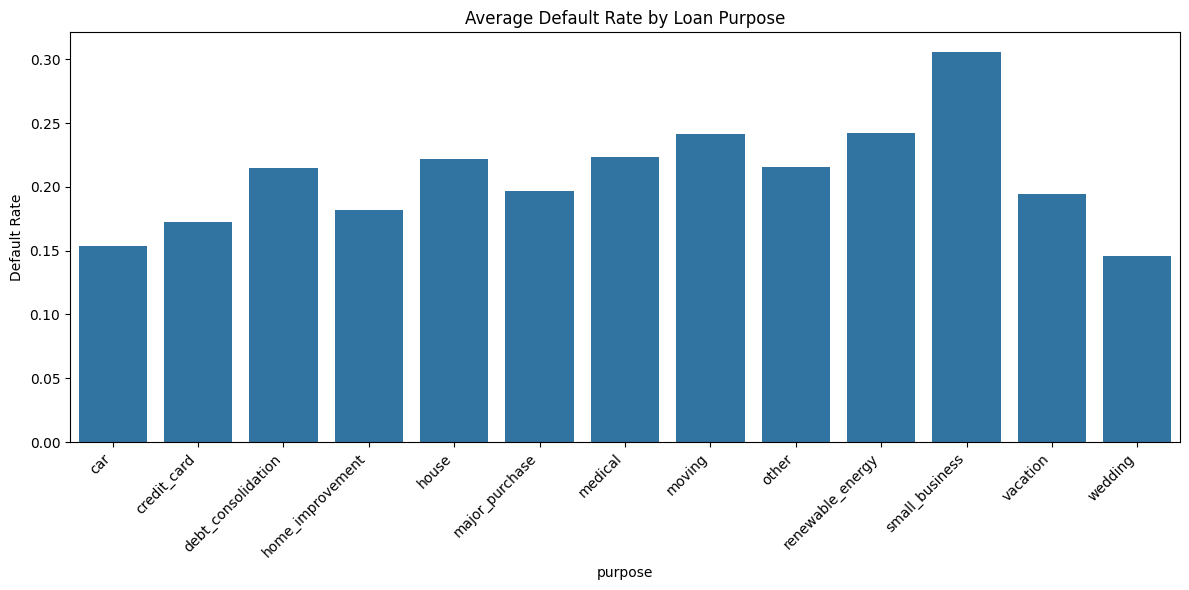

In [12]:
# Deefault Rate by Loan Purpose

# Convert Spark DataFrame to Pandas DataFrame for EDA
purpose_pd = df_clean.select("purpose", "default_flag").dropna().toPandas()

# Remove invalid/rare/malformed loan purposes
valid_purposes = [
    'debt_consolidation', 'credit_card', 'home_improvement', 'major_purchase', 'small_business',
    'car', 'medical', 'moving', 'vacation', 'house', 'wedding', 'renewable_energy', 'other'
]
purpose_pd = purpose_pd[purpose_pd["purpose"].isin(valid_purposes)]

# Group and calculate average default rate by loan purpose
default_rate_by_purpose = purpose_pd.groupby("purpose")["default_flag"].mean().reset_index()

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(data=default_rate_by_purpose, x="purpose", y="default_flag")
plt.title("Average Default Rate by Loan Purpose")
plt.ylabel("Default Rate")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

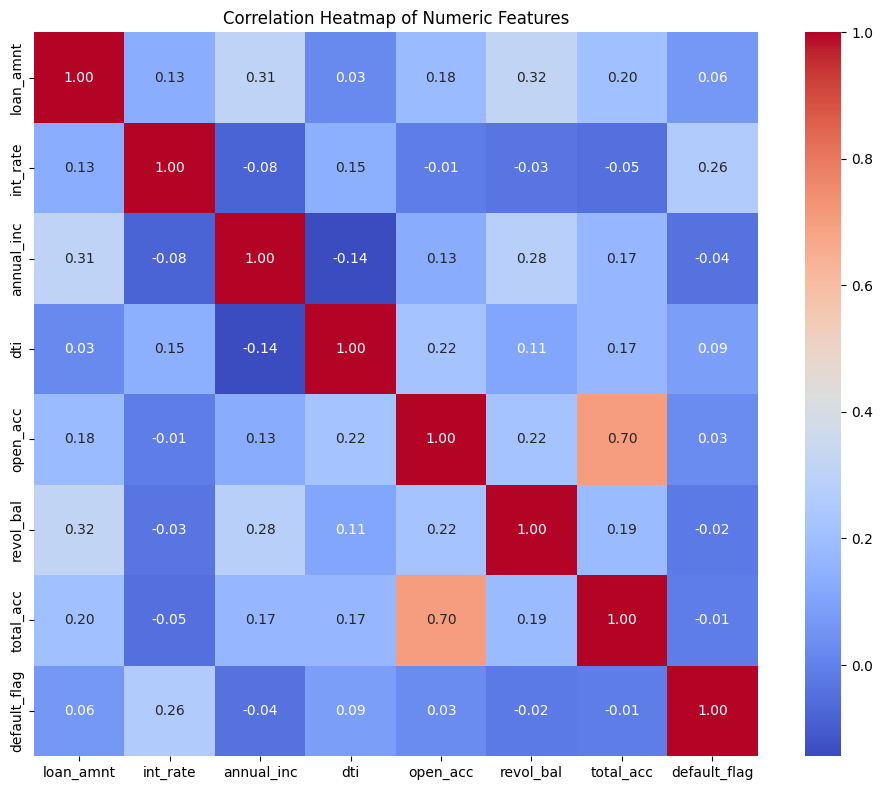

In [13]:
# Correlation Heatmap (Numeric Features)

# Relevant numeric columns
numeric_features = [
    "loan_amnt", "int_rate", "annual_inc", "dti",
    "open_acc", "revol_bal", "total_acc", "default_flag"
]

# Convert to Pandas DataFrame
correlation_df = df_clean.select(numeric_features).dropna().toPandas()

# Compute correlation matrix
correlation_matrix = correlation_df.corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", square=True)
plt.title("Correlation Heatmap of Numeric Features")
plt.tight_layout()
plt.show()

## 3. Feature Engineering

In [14]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

In [15]:
# Step 1: Encode Categorical 

categorical_cols = ["term", "grade", "home_ownership", "verification_status", "purpose"]

# Apply StringIndexer
indexers = [StringIndexer(inputCol=col, outputCol=col+"_idx", handleInvalid='keep') for col in categorical_cols]

# Apply OneHotEncoder
encoder = OneHotEncoder(inputCols=[col+"_idx" for col in categorical_cols],
                        outputCols=[col+"_vec" for col in categorical_cols])

# Apply the transformations
pipeline = Pipeline(stages=indexers + [encoder])
df_clean = pipeline.fit(df_clean).transform(df_clean)

In [16]:
# Step 2: UDF: Categorize interest rate

def interest_rate_category(rate):
    if rate < 10:
        return "Low"
    elif rate < 20:
        return "Medium"
    else:
        return "High"

interest_udf = udf(interest_rate_category, StringType())
df_clean = df_clean.withColumn("int_rate_category", interest_udf(col("int_rate")))

In [17]:
# Step 3: Normalize Numerical Features

# Drop nulls in numeric columns before assembling
df_clean = df_clean.dropna(subset=numeric_cols)

assembler_numeric = VectorAssembler(inputCols=numeric_cols, outputCol="numeric_features")
df_clean = assembler_numeric.transform(df_clean)

scaler = StandardScaler(inputCol="numeric_features", outputCol="scaled_numeric_features", withMean=True, withStd=True)
df_clean = scaler.fit(df_clean).transform(df_clean)

In [18]:
# Step 4: Assemble All Features

feature_cols = ["scaled_numeric_features"] + [col+"_vec" for col in categorical_cols]

assembler_final = VectorAssembler(inputCols=feature_cols, outputCol="features")
df_clean = assembler_final.transform(df_clean)

print("Final feature assembler ready.")

Final feature assembler ready.


In [19]:
# Step 5: Add Class Weights

# Calculate class distribution
class_dist = df_clean.groupBy("default_flag").count().toPandas()
minority = class_dist[class_dist['default_flag'] == 1]['count'].values[0]
majority = class_dist[class_dist['default_flag'] == 0]['count'].values[0]
ratio = majority / minority

# Add weight column to training set
df_clean = df_clean.withColumn("class_weight", when(col("default_flag") == 1, ratio).otherwise(1.0))

## 4. Model Building & Evaluation

In [20]:
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, MultilayerPerceptronClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, precision_score, recall_score, f1_score

In [21]:
# Step 1: Train-Test Split
train_data, test_data = df_clean.randomSplit([0.8, 0.2], seed=42)
print("Training Data Count:", train_data.count())
print("Test Data Count:", test_data.count())

Training Data Count: 989427
Test Data Count: 246338


In [22]:
# Step 2: Evaluation Function
def evaluate_model(predictions, model_name):
    evaluator = BinaryClassificationEvaluator(labelCol="default_flag")
    auc = evaluator.evaluate(predictions)
    print(f"\n{model_name} AUC: {auc:.4f}")

    pred_pd = predictions.select("prediction", "default_flag").toPandas()
    cm = confusion_matrix(pred_pd["default_flag"], pred_pd["prediction"])
    precision = precision_score(pred_pd["default_flag"], pred_pd["prediction"], zero_division=0)
    recall = recall_score(pred_pd["default_flag"], pred_pd["prediction"], zero_division=0)
    f1 = f1_score(pred_pd["default_flag"], pred_pd["prediction"], zero_division=0)

    print("Confusion Matrix:")
    print(cm)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)
    print("Classification Report:")
    print(classification_report(pred_pd["default_flag"], pred_pd["prediction"]))

In [23]:
# Step 3: Model Building

# 1. Logistic Regression with Class Weight:

lr = LogisticRegression(labelCol="default_flag", featuresCol="features", weightCol="class_weight")
lr_model = lr.fit(train_data)
lr_predictions = lr_model.transform(test_data)
evaluate_model(lr_predictions, "Logistic Regression")


Logistic Regression AUC: 0.7066
Confusion Matrix:
[[123237  73104]
 [ 16296  33701]]
Precision: 0.3155376620944712
Recall: 0.6740604436266175
F1 Score: 0.42985421104322646
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.63      0.73    196341
           1       0.32      0.67      0.43     49997

    accuracy                           0.64    246338
   macro avg       0.60      0.65      0.58    246338
weighted avg       0.77      0.64      0.67    246338



In [24]:
# 2. Random Forest:

rf = RandomForestClassifier(labelCol="default_flag", featuresCol="features")
rf_model = rf.fit(train_data)
rf_predictions = rf_model.transform(test_data)
evaluate_model(rf_predictions, "Random Forest")


Random Forest AUC: 0.6939
Confusion Matrix:
[[196341      0]
 [ 49997      0]]
Precision: 0.0
Recall: 0.0
F1 Score: 0.0
Classification Report:


C:\Users\yorbi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\yorbi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.80      1.00      0.89    196341
           1       0.00      0.00      0.00     49997

    accuracy                           0.80    246338
   macro avg       0.40      0.50      0.44    246338
weighted avg       0.64      0.80      0.71    246338



C:\Users\yorbi\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [25]:
# 3. Artificial Neural Network

input_dim = df_clean.select("features").first()["features"].size
ann = MultilayerPerceptronClassifier(labelCol="default_flag", featuresCol="features",
                                     maxIter=100, layers=[input_dim, 32, 16, 2],
                                     blockSize=128, seed=123)
ann_model = ann.fit(train_data)
ann_predictions = ann_model.transform(test_data)
evaluate_model(ann_predictions, "ANN (Multilayer Perceptron)")


ANN (Multilayer Perceptron) AUC: 0.7081
Confusion Matrix:
[[193511   2830]
 [ 46534   3463]]
Precision: 0.5502939774352456
Recall: 0.06926415584935096
F1 Score: 0.12304139278735121
Classification Report:
              precision    recall  f1-score   support

           0       0.81      0.99      0.89    196341
           1       0.55      0.07      0.12     49997

    accuracy                           0.80    246338
   macro avg       0.68      0.53      0.50    246338
weighted avg       0.75      0.80      0.73    246338



In [26]:
# 4. XGBoost Model

from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV
import numpy as np

In [27]:
# Convert training and test data to Pandas
train_pd = train_data.select("features", "default_flag").toPandas()
test_pd = test_data.select("features", "default_flag").toPandas()

X_train = np.array([x.toArray() for x in train_pd['features']])
y_train = train_pd['default_flag'].values
X_test = np.array([x.toArray() for x in test_pd['features']])
y_test = test_pd['default_flag'].values

In [28]:
# Hyperparameter tuning
param_grid = {
    'max_depth': [3, 5],
    'learning_rate': [0.1, 0.2],
    'n_estimators': [100, 200],
    'subsample': [0.8],
    'colsample_bytree': [0.8]
}

grid = GridSearchCV(XGBClassifier(use_label_encoder=False, eval_metric='logloss'),
                    param_grid, cv=3, scoring='roc_auc', verbose=1, n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_

Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\yorbi\AppData\Local\Programs\Python\Python39\lib\site-packages\xgboost\core.py:158: UserWarning: [08:21:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


In [29]:
# Evaluate the model
xgb_preds = best_model.predict(X_test)
xgb_auc = roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1])
print(f"\nXGBoost AUC: {xgb_auc:.4f}")
print("Confusion Matrix:")
print(confusion_matrix(y_test, xgb_preds))
print("Classification Report:")
print(classification_report(y_test, xgb_preds))


XGBoost AUC: 0.7111
Confusion Matrix:
[[194106   2235]
 [ 47169   2828]]
Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.99      0.89    196341
           1       0.56      0.06      0.10     49997

    accuracy                           0.80    246338
   macro avg       0.68      0.52      0.49    246338
weighted avg       0.75      0.80      0.73    246338



## 5. Visualization & Reporting

In [30]:
from sklearn.metrics import ConfusionMatrixDisplay, roc_curve, auc
import pandas as pd
import numpy as np

In [31]:
# Prepare Data for ROC Curve Comparison
model_names = ["Logistic Regression", "Random Forest", "ANN", "XGBoost"]
probas = [
    lr_predictions.select("default_flag", "probability").toPandas(),
    rf_predictions.select("default_flag", "probability").toPandas(),
    ann_predictions.select("default_flag", "probability").toPandas(),
    pd.DataFrame({"default_flag": y_test, "probability": best_model.predict_proba(X_test)[:, 1]})
]

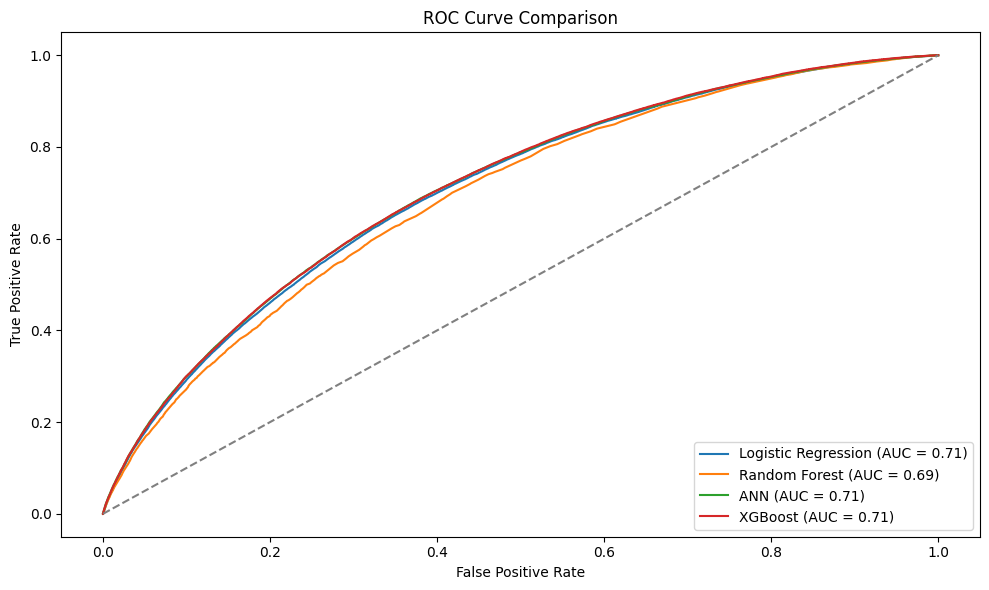

In [32]:
# Plot ROC Curves
plt.figure(figsize=(10, 6))
for name, data in zip(model_names, probas):
    y_true = data["default_flag"]
    y_score = data["probability"].apply(lambda x: x[1] if isinstance(x, list) or hasattr(x, '__getitem__') else x)
    fpr, tpr, _ = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.tight_layout()
plt.show()

### *Comment:*

The ROC Curve shows how well each model distinguishes between defaulters and non-defaulters.

* All models have similar AUCs (~0.71), meaning they perform better than random guessing, but not exceptionally.
* XGBoost has the highest AUC (0.7111), making it slightly better at ranking borrowers by risk.
* However, AUC alone doesn’t reflect real-world costs (e.g., misclassifying defaulters), so we must combine it with other metrics like recall.

For our goal (identifying risky first-time borrowers), we need models that minimize false negatives, even if it means more false positives. So we must look at recall and confusion matrices.

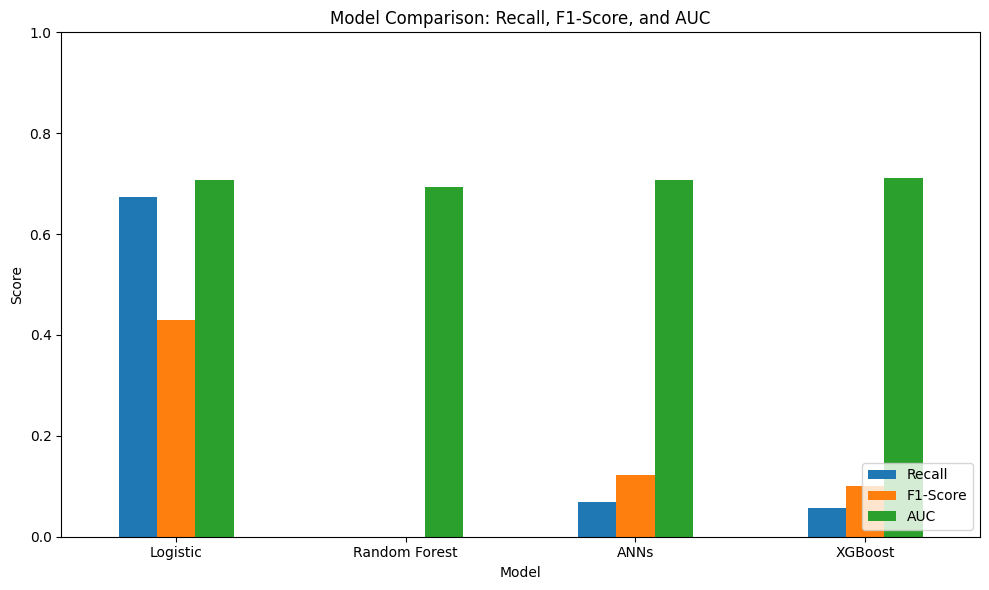

In [33]:
# Bar Chart Comparing Recall, F1, and AUC for Each Model
metrics_df = pd.DataFrame({
    'Model': ["Logistic", "Random Forest", "ANNs", "XGBoost"],
    'Recall': [0.6741, 0.0000, 0.0693, 0.0566],
    'F1-Score': [0.4299, 0.0000, 0.1230, 0.1000],
    'AUC': [0.7066, 0.6936, 0.7081, 0.7111]
})

metrics_df.set_index('Model', inplace=True)
metrics_df.plot(kind='bar', figsize=(10, 6), rot=0)
plt.title("Model Comparison: Recall, F1-Score, and AUC")
plt.ylabel("Score")
plt.ylim(0, 1)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()

### *Comment:*

This chart compares each model using Recall, F1-Score, and AUC:

* Recall (ability to catch defaulters) is highest for Logistic Regression (0.67) — crucial for our use case.
* F1-Score (balance of precision and recall) is also best for Logistic Regression (0.42).
* Other models, especially Random Forest, fail to detect defaulters (Recall = 0.00), so they're unsuitable.

For our goal of risk prediction, Logistic Regression offers the most practical value:
* It captures more risky borrowers.
* It ensures lending decisions are more cautious and safer.

Models with high AUC but low recall (like Random Forest or XGBoost) may look good technically, but pose a real risk of approving loans to defaulters.

In [34]:
# Confusion Matrix Heatmaps
from sklearn.metrics import confusion_matrix

def plot_conf_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(title)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

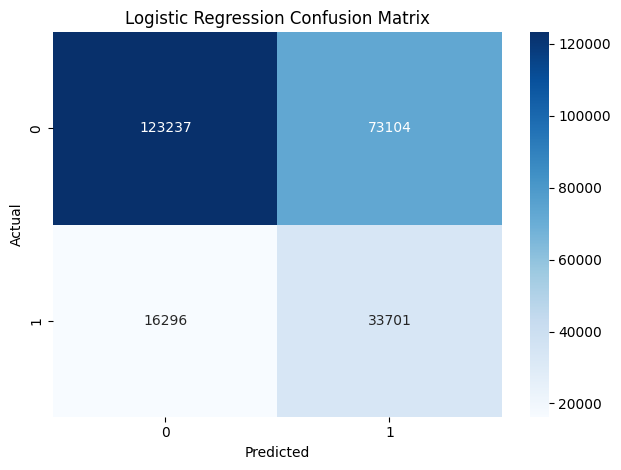

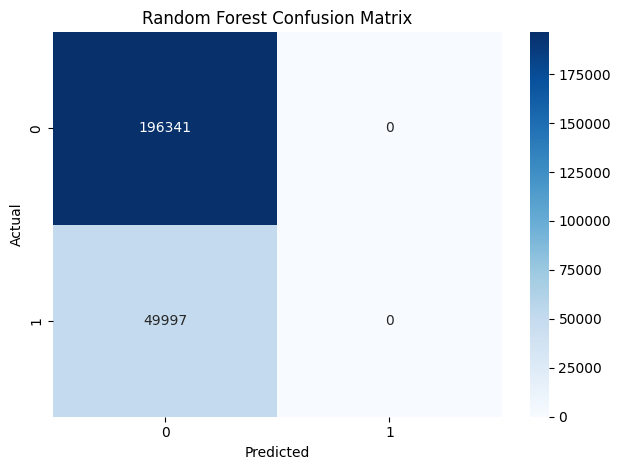

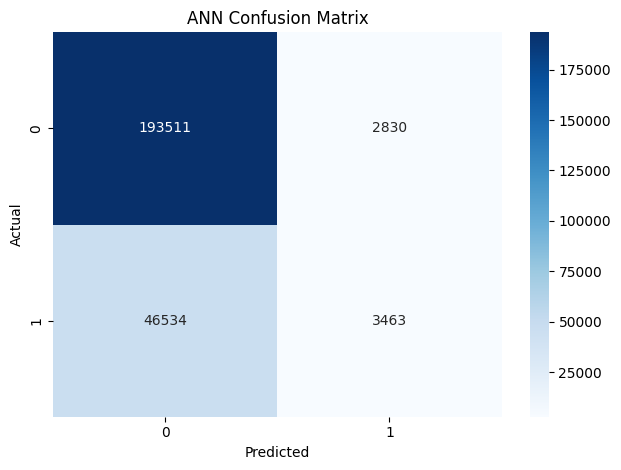

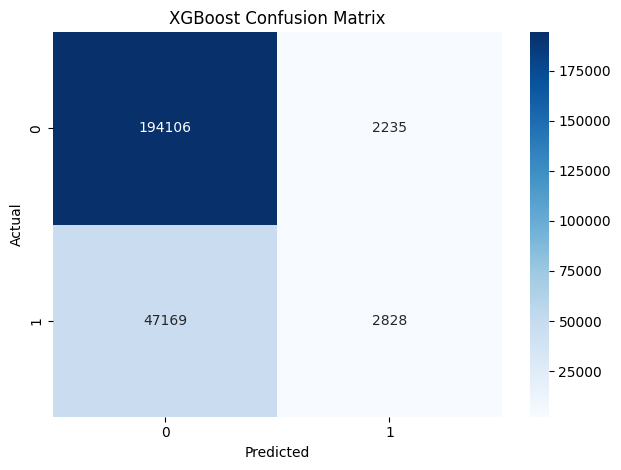

In [35]:
# Logistic Regression Confusion Matrix
lr_pd = lr_predictions.select("prediction", "default_flag").toPandas()
plot_conf_matrix(lr_pd["default_flag"], lr_pd["prediction"], "Logistic Regression Confusion Matrix")

# Random Forest Confusion Matrix
rf_pd = rf_predictions.select("prediction", "default_flag").toPandas()
plot_conf_matrix(rf_pd["default_flag"], rf_pd["prediction"], "Random Forest Confusion Matrix")

# ANN Confusion Matrix
ann_pd = ann_predictions.select("prediction", "default_flag").toPandas()
plot_conf_matrix(ann_pd["default_flag"], ann_pd["prediction"], "ANN Confusion Matrix")

# XGBoost Confusion Matrix
plot_conf_matrix(y_test, xgb_preds, "XGBoost Confusion Matrix")

### *Comment:*

Logistic Regression:

* Identified 33,701 defaulters correctly.
* Missed 16,296 real defaulters.
* Best balance so far — better for early warning, even if it overflags some safe borrowers (false positives = 73,104).

Random Forest:

* Failed to detect any defaulters (0 true positives).
* Extremely high false negatives (49,997) — not usable for our goal.

ANN & XGBoost:

* Detected a small number of defaulters (ANN: 3,463, XGBoost: 2,828).
* Missed ~46–47K defaulters, so not great in isolation.
* Fewer false positives, but too cautious, which is risky in our context.

*Conclusion:* We prefer a model like Logistic Regression, which captures more defaulters even if it has a higher false alarm rate. Missing risky borrowers is more costly than mistakenly flagging safe ones.

In [36]:
final_preds = lr_predictions.select("default_flag", "prediction", "probability").toPandas()
final_preds.to_csv("final_predictions.csv", index=False)
